# 패키지 다운로드

In [ ]:
# pip install xarray

# 패키지 로딩

In [20]:
import xarray as xr

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

import warnings

warnings.filterwarnings("ignore")

# 종속변수(SCTR) 전처리

## nc -> csv 변환

In [ ]:
ds = xr.open_dataset('./data/EN.4.2.2_D20_SCTR_f.nc')

df = ds.D20_SCTR.to_dataframe()

df.reset_index(inplace=True)

df.to_csv('./output/SCTR.csv', index=False)

ds.close()

# 종속변수 불러오기

In [3]:
sctr = pd.read_csv("./output/SCTR.csv")

# 날짜 형식 통일
sctr["TIME1"] = pd.to_datetime(sctr["TIME1"])
sctr["TIME1"] = sctr["TIME1"].dt.to_period('M').dt.to_timestamp()

# 날짜 컬럼 이름 변경
sctr = sctr.rename(columns={"TIME1":"Date"})

sctr

,Date,D20_SCTR
0,1991-01-01,54.960640
1,1991-02-01,59.899442
2,1991-03-01,70.225124
3,1991-04-01,67.375125
4,1991-05-01,63.783066
...,...,...
395,2023-12-01,124.376897
396,2024-01-01,117.300079
397,2024-02-01,121.968669
398,2024-03-01,118.355688


# 독립변수 전처리

## IOD
- WTIO  : 동경 50도 ~ 70도, 남위 10도 ~ 북위 10도에서 SST 편차의 평균 
- SETIO : 동경 90도 ~ 110도, 남위 10도 ~ 적도선에서 SST 편차의 평균
- DMI  = WTIO - SETIO

### txt -> csv 변환

In [ ]:
IOD = pd.read_csv("./data/IOD.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
IOD['Date'] = pd.to_datetime(IOD['Year'].astype(str) + '-' + IOD['Month'].astype(str) + '-01')
IOD = IOD.drop(["Year", "Month"], axis = 1)
IOD = IOD[["Date", "WTIO", "SETIO"]]

# DMI(Dipole Mode Index) 컬럼 생성
IOD["DMI"] = IOD["WTIO"] - IOD["SETIO"]

IOD.to_csv("./output/IOD.csv", encoding="utf-8-sig", index=False)

In [ ]:
IOD = pd.read_csv("./output/IOD.csv")

IOD

## ONI

### txt -> csv 변환

In [ ]:
ONI = pd.read_csv("./data/ONI.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
ONI['Date'] = pd.to_datetime(ONI['Date'].astype(str) + '-01')

ONI.to_csv("./output/ONI.csv", encoding="utf-8-sig", index=False)

In [ ]:
ONI = pd.read_csv("./output/ONI.csv")

ONI

## OISST
- NINO 3.4(북위 5도 ~ 남위 5도, 서경 170도 ~ 120도)의 평균 해수면 온도 & 편차

### txt -> csv 변환

In [ ]:
OISST = pd.read_csv("./data/OISST.txt", sep="\t", encoding="cp949")

OISST['Date'] = pd.to_datetime(OISST['Date'])

OISST.to_csv("./output/OISST.csv", encoding="utf-8-sig", index=False)

In [ ]:
OISST = pd.read_csv("./output/OISST.csv")

OISST

## SOI
- 남방진동지수, Darwin - Tahiti 사이의 표준화된 해면기압 차이

### txt -> csv 변환

In [ ]:
SOI = pd.read_csv("./data/SOI.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
SOI['Date'] = pd.to_datetime(SOI['Date'].astype(str) + '-01')

SOI.to_csv("./output/SOI.csv", encoding="utf-8-sig", index=False)

In [ ]:
SOI = pd.read_csv("./output/SOI.csv")

SOI

## 독립변수 합치기

In [ ]:
df = pd.merge(IOD, ONI, on="Date")
df = pd.merge(df, OISST, on="Date")
df = pd.merge(df, SOI, on="Date")

df.to_csv("./output/IND.csv", encoding="utf-8-sig", index=False)

# 독립변수 불러오기 & 종속변수 합치기

In [5]:
ind = pd.read_csv("./output/IND.csv")

ind["Date"] = pd.to_datetime(ind["Date"])

data = pd.merge(ind, sctr, on="Date").drop("Date", axis = 1)

data.to_csv("./output/data.csv", encoding="cp949", index=False)

In [6]:
data = pd.read_csv("./output/data.csv")

data

,WTIO,SETIO,DMI,ONI,NINO3.4,ANOM,SOI,D20_SCTR
0,0.18,0.12,0.06,0.41,26.89,0.33,0.6,54.960640
1,0.05,-0.04,0.09,0.26,26.87,0.14,0.3,59.899442
2,-0.04,0.02,-0.06,0.22,27.16,-0.08,-0.7,70.225124
3,0.31,-0.45,0.76,0.26,27.89,0.08,-0.6,67.375125
4,0.28,-0.62,0.90,0.45,28.13,0.25,-1.0,63.783066
...,...,...,...,...,...,...,...,...
395,1.14,-0.07,1.21,1.95,28.64,1.99,-0.2,124.376897
396,1.18,0.36,0.82,1.79,28.34,1.78,0.5,117.300079
397,1.22,0.92,0.30,1.49,28.26,1.53,-1.4,121.968669
398,0.95,0.41,0.54,1.14,28.47,1.24,0.4,118.355688


# OISST 빼기(NINO3.4, ANOM)

In [7]:
data = data.drop(["NINO3.4", "ANOM"], axis = 1)

data

,WTIO,SETIO,DMI,ONI,SOI,D20_SCTR
0,0.18,0.12,0.06,0.41,0.6,54.960640
1,0.05,-0.04,0.09,0.26,0.3,59.899442
2,-0.04,0.02,-0.06,0.22,-0.7,70.225124
3,0.31,-0.45,0.76,0.26,-0.6,67.375125
4,0.28,-0.62,0.90,0.45,-1.0,63.783066
...,...,...,...,...,...,...
395,1.14,-0.07,1.21,1.95,-0.2,124.376897
396,1.18,0.36,0.82,1.79,0.5,117.300079
397,1.22,0.92,0.30,1.49,-1.4,121.968669
398,0.95,0.41,0.54,1.14,0.4,118.355688


# 중간정리
- IOD(WTIO, SETIO, DMI)는 WTIO, SETIO / DMI로 나눠서 모델 구성
- SOI는 이미 표준화되어 있으므로 표준화 O, X 나눠서 모델 구성

# 함수 로딩

In [8]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i + target_size])
            
    return np.array(data), np.array(labels)

In [9]:
def plot_train_history(history, function):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))
    
    plt.rcParams['font.family'] ='Malgun Gothic'
    plt.figure(figsize=(12, 8))
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    
    plt.xlabel("Epoch")
    plt.ylabel(function)
    
    plt.title("모델 손실함수 시각화")
    plt.legend()
    plt.grid()

    plt.show()

# Case1) WTIO, SETIO & SOI 표준화

## 데이터 전처리

In [10]:
case1_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'D20_SCTR']]

case1_dts = case1_df.values

case1_mean = case1_dts.mean(axis=0)
case1_std = case1_dts.std(axis=0)
case1_dts = (case1_dts-case1_mean)/case1_std

In [11]:
case1_df

,WTIO,SETIO,ONI,SOI,D20_SCTR
0,0.18,0.12,0.41,0.6,54.960640
1,0.05,-0.04,0.26,0.3,59.899442
2,-0.04,0.02,0.22,-0.7,70.225124
3,0.31,-0.45,0.26,-0.6,67.375125
4,0.28,-0.62,0.45,-1.0,63.783066
...,...,...,...,...,...
395,1.14,-0.07,1.95,-0.2,124.376897
396,1.18,0.36,1.79,0.5,117.300079
397,1.22,0.92,1.49,-1.4,121.968669
398,0.95,0.41,1.14,0.4,118.355688


In [12]:
len(case1_dts)

400

## 하이퍼 파라매터 세팅

In [30]:
# 학습(0.7) - 평가(0.2) - 검증(0.1) 데이터 분리
TRAIN_SPLIT = int(len(case1_dts) * 0.7)
TEST_SPLIT = int(len(case1_dts) * 0.2)

BATCH_SIZE = 16
EPOCHS = 200

# 12개월 학습 - 12개월 예측
past_history = 12
future_target = 12
STEP = 1

tf.random.set_seed(13)

In [14]:
TRAIN_SPLIT

280

In [15]:
TEST_SPLIT

80

## 데이터 분리

In [17]:
# 전체 데이터 길이
total_length = len(case1_dts)

# 학습(0.7) - 검증(0.2) - 테스트(0.1) 데이터 분리
TRAIN_SPLIT = int(total_length * 0.7)
VAL_SPLIT = int(total_length * 0.2)
TEST_SPLIT = total_length - TRAIN_SPLIT - VAL_SPLIT

# 12개월 학습 - 12개월 예측
past_history = 12
future_target = 12
STEP = 1

# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case1_dts, case1_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"테스트 데이터 형태: {x_test_multi.shape}")

print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 5)
검증 데이터 형태: (56, 12, 5)
테스트 데이터 형태: (16, 12, 5)
과거 데이터 윈도우 형태: (12, 5)
예측 목표 기간 형태: (12,)


In [18]:
BUFFER_SIZE = 100

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))

train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

## 모델 학습

### 단방향 LSTM

Epoch 1/200
16/16 [==============================] - 7s 88ms/step - loss: 19.2811 - val_loss: 18.6042 - lr: 5.0000e-04
Epoch 2/200
16/16 [==============================] - 1s 32ms/step - loss: 18.2180 - val_loss: 17.7634 - lr: 5.0000e-04
Epoch 3/200
16/16 [==============================] - 1s 35ms/step - loss: 17.2369 - val_loss: 16.8970 - lr: 5.0000e-04
Epoch 4/200
16/16 [==============================] - 1s 37ms/step - loss: 16.2286 - val_loss: 16.0206 - lr: 5.0000e-04
Epoch 5/200
16/16 [==============================] - 1s 36ms/step - loss: 15.2918 - val_loss: 15.1476 - lr: 5.0000e-04
Epoch 6/200
16/16 [==============================] - 1s 38ms/step - loss: 14.3509 - val_loss: 14.2858 - lr: 5.0000e-04
Epoch 7/200
16/16 [==============================] - 1s 38ms/step - loss: 13.4716 - val_loss: 13.4464 - lr: 5.0000e-04
Epoch 8/200
16/16 [==============================] - 1s 50ms/step - loss: 12.6000 - val_loss: 12.6375 - lr: 5.0000e-04
Epoch 9/200
16/16 [=============================

16/16 [==============================] - 1s 31ms/step - loss: 1.5110 - val_loss: 2.3771 - lr: 5.0000e-04
Epoch 71/200
16/16 [==============================] - 1s 32ms/step - loss: 1.4777 - val_loss: 2.2138 - lr: 5.0000e-04
Epoch 72/200
16/16 [==============================] - 1s 32ms/step - loss: 1.4700 - val_loss: 2.2395 - lr: 5.0000e-04
Epoch 73/200
16/16 [==============================] - 0s 31ms/step - loss: 1.4475 - val_loss: 2.2215 - lr: 5.0000e-04
Epoch 74/200
16/16 [==============================] - 0s 31ms/step - loss: 1.4233 - val_loss: 2.3272 - lr: 5.0000e-04
Epoch 75/200
16/16 [==============================] - 1s 31ms/step - loss: 1.4189 - val_loss: 2.1772 - lr: 5.0000e-04
Epoch 76/200
16/16 [==============================] - 1s 32ms/step - loss: 1.3976 - val_loss: 2.1645 - lr: 5.0000e-04
Epoch 77/200
16/16 [==============================] - 1s 32ms/step - loss: 1.3644 - val_loss: 2.1475 - lr: 5.0000e-04
Epoch 78/200
16/16 [==============================] - 0s 31ms/step - 

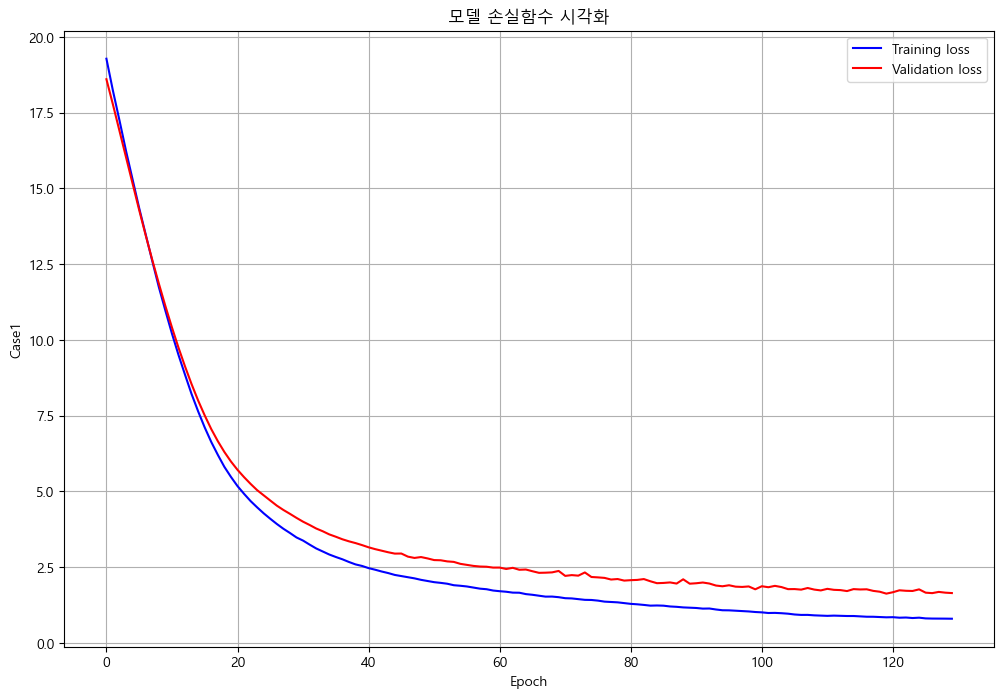

In [37]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
    
initial_lr = 0.0005

optimizer = Adam(learning_rate=initial_lr)
# optimizer = RMSprop(learning_rate=initial_lr, clipvalue=1.0)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

multi_step_model = Sequential()

multi_step_model.add(LSTM(128, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005),    
                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(BatchNormalization())
multi_step_model.add(Dropout(0.3))

multi_step_model.add(LSTM(64, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
multi_step_model.add(BatchNormalization())
multi_step_model.add(Dropout(0.3))

multi_step_model.add(LSTM(32, activation='relu',
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
multi_step_model.add(BatchNormalization())
multi_step_model.add(Dropout(0.3))

multi_step_model.add(Dense(24, activation='relu'))
multi_step_model.add(Dense(12))

multi_step_model.compile(optimizer=optimizer, loss='mse')

multi_step_history = multi_step_model.fit(
    train_data_multi, 
    epochs = EPOCHS, 
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_data = val_data_multi, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[
        lr_restart, 
        early_stop
    ])

plot_train_history(multi_step_history, "Case1, Sequantial")

In [46]:
y_hat = multi_step_model.predict(x_test_multi)

1/1 [==============================] - 0s 28ms/step


In [64]:
y_test_multi * case1_std[-1] + case1_mean[-1]

array([[ 66.53163657,  72.05824167,  80.78846186,  84.04567489,
         74.96824028,  65.41161582,  73.7607646 ,  91.19500174,
         87.56204169,  82.4824271 ,  76.56168518,  62.86492585],
       [ 72.05824167,  80.78846186,  84.04567489,  74.96824028,
         65.41161582,  73.7607646 ,  91.19500174,  87.56204169,
         82.4824271 ,  76.56168518,  62.86492585,  58.59032098],
       [ 80.78846186,  84.04567489,  74.96824028,  65.41161582,
         73.7607646 ,  91.19500174,  87.56204169,  82.4824271 ,
         76.56168518,  62.86492585,  58.59032098,  58.42825434],
       [ 84.04567489,  74.96824028,  65.41161582,  73.7607646 ,
         91.19500174,  87.56204169,  82.4824271 ,  76.56168518,
         62.86492585,  58.59032098,  58.42825434,  67.97922018],
       [ 74.96824028,  65.41161582,  73.7607646 ,  91.19500174,
         87.56204169,  82.4824271 ,  76.56168518,  62.86492585,
         58.59032098,  58.42825434,  67.97922018,  74.99556303],
       [ 65.41161582,  73.7607646 ,

In [67]:
y_hat * case1_std[-1] + case1_mean[-1]

array([[77.43837 , 77.533485, 76.98557 , 78.43054 , 78.37962 , 79.21962 ,
        78.67696 , 80.48964 , 80.911415, 81.98148 , 81.264015, 81.69432 ],
       [76.33414 , 76.73992 , 76.302   , 77.895226, 78.22706 , 79.605774,
        79.321686, 81.67068 , 81.968994, 83.66368 , 82.8256  , 82.35334 ],
       [75.44022 , 76.42435 , 76.1799  , 78.43377 , 79.230125, 80.05727 ,
        79.42214 , 82.451164, 81.96303 , 83.224236, 82.36063 , 82.48896 ],
       [75.38142 , 76.67297 , 76.682495, 79.54083 , 80.36213 , 81.21143 ,
        80.68366 , 83.87568 , 82.97671 , 83.86115 , 83.25229 , 82.799736],
       [75.394394, 76.60482 , 77.03526 , 79.88261 , 80.54215 , 81.51931 ,
        81.16632 , 84.33454 , 83.29252 , 84.07874 , 83.66098 , 83.18022 ],
       [75.83136 , 76.72274 , 76.46883 , 79.05684 , 79.43672 , 79.97554 ,
        79.443245, 82.15938 , 81.297485, 82.25769 , 81.61766 , 82.035164],
       [76.78632 , 77.071144, 76.887596, 77.91098 , 78.23813 , 79.18089 ,
        78.638794, 80.02928 , 79

### 양방향 LSTM

Epoch 1/200
16/16 [==============================] - 10s 152ms/step - loss: 55.2604 - val_loss: 52.9942 - lr: 5.0000e-04
Epoch 2/200
16/16 [==============================] - 1s 51ms/step - loss: 50.9917 - val_loss: 48.9224 - lr: 5.0000e-04
Epoch 3/200
16/16 [==============================] - 1s 50ms/step - loss: 46.7743 - val_loss: 44.8406 - lr: 5.0000e-04
Epoch 4/200
16/16 [==============================] - 1s 52ms/step - loss: 42.6753 - val_loss: 40.8615 - lr: 5.0000e-04
Epoch 5/200
16/16 [==============================] - 1s 50ms/step - loss: 38.7148 - val_loss: 37.0610 - lr: 5.0000e-04
Epoch 6/200
16/16 [==============================] - 1s 49ms/step - loss: 34.9457 - val_loss: 33.4481 - lr: 5.0000e-04
Epoch 7/200
16/16 [==============================] - 1s 45ms/step - loss: 31.3743 - val_loss: 30.0458 - lr: 5.0000e-04
Epoch 8/200
16/16 [==============================] - 1s 46ms/step - loss: 28.0512 - val_loss: 26.8769 - lr: 5.0000e-04
Epoch 9/200
16/16 [===========================

16/16 [==============================] - 1s 50ms/step - loss: 2.3424 - val_loss: 3.1369 - lr: 5.0000e-04
Epoch 71/200
16/16 [==============================] - 1s 51ms/step - loss: 2.2865 - val_loss: 3.0360 - lr: 5.0000e-04
Epoch 72/200
16/16 [==============================] - 1s 53ms/step - loss: 2.2432 - val_loss: 2.9682 - lr: 5.0000e-04
Epoch 73/200
16/16 [==============================] - 1s 51ms/step - loss: 2.2101 - val_loss: 3.0591 - lr: 5.0000e-04
Epoch 74/200
16/16 [==============================] - 1s 49ms/step - loss: 2.1809 - val_loss: 2.9644 - lr: 5.0000e-04
Epoch 75/200
16/16 [==============================] - 1s 50ms/step - loss: 2.1447 - val_loss: 2.8646 - lr: 5.0000e-04
Epoch 76/200
16/16 [==============================] - 1s 52ms/step - loss: 2.1148 - val_loss: 2.8538 - lr: 5.0000e-04
Epoch 77/200
16/16 [==============================] - 1s 50ms/step - loss: 2.0844 - val_loss: 2.8556 - lr: 5.0000e-04
Epoch 78/200
16/16 [==============================] - 1s 50ms/step - 

16/16 [==============================] - 1s 56ms/step - loss: 0.8248 - val_loss: 1.6012 - lr: 2.5000e-04
Epoch 139/200
16/16 [==============================] - 1s 56ms/step - loss: 0.8059 - val_loss: 1.5076 - lr: 2.5000e-04
Epoch 140/200
16/16 [==============================] - 1s 67ms/step - loss: 0.8067 - val_loss: 1.5190 - lr: 2.5000e-04
Epoch 141/200
16/16 [==============================] - 1s 60ms/step - loss: 0.7951 - val_loss: 1.5953 - lr: 2.5000e-04
Epoch 142/200
16/16 [==============================] - 1s 64ms/step - loss: 0.7947 - val_loss: 1.5350 - lr: 2.5000e-04
Epoch 143/200
16/16 [==============================] - 1s 66ms/step - loss: 0.7835 - val_loss: 1.5903 - lr: 2.5000e-04
Epoch 144/200
16/16 [==============================] - 1s 52ms/step - loss: 0.7701 - val_loss: 1.4928 - lr: 2.5000e-04
Epoch 145/200
16/16 [==============================] - 1s 48ms/step - loss: 0.7676 - val_loss: 1.5173 - lr: 2.5000e-04
Epoch 146/200
16/16 [==============================] - 1s 48ms

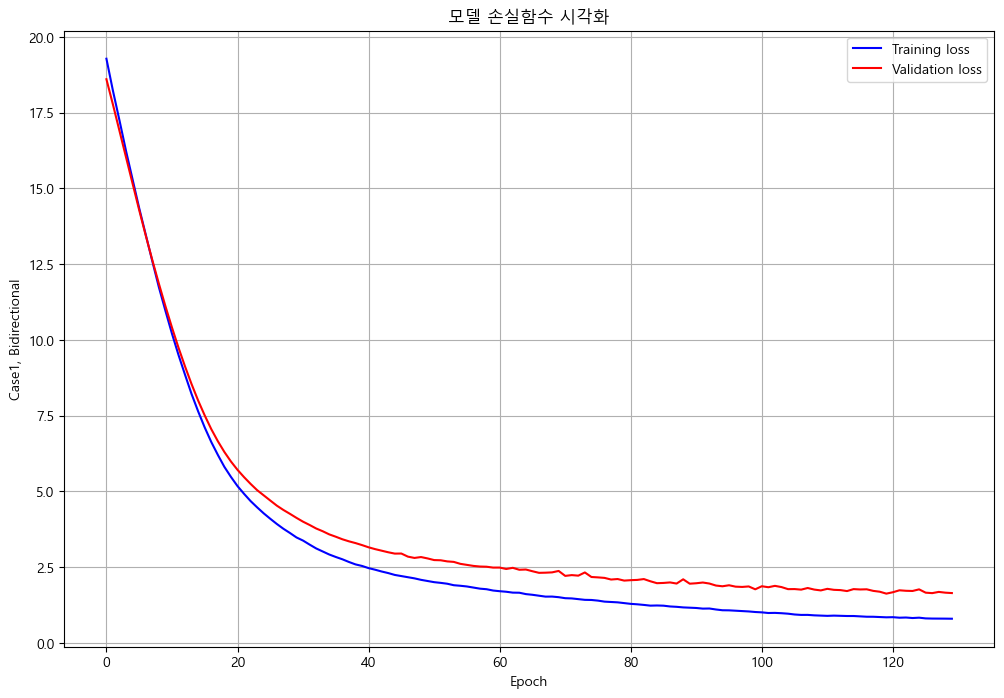

In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention, Concatenate
from tensorflow.keras.regularizers import l1_l2

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 정의
inputs = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))

# 첫 번째 Bidirectional LSTM 레이어
x = Bidirectional(LSTM(128, return_sequences=True,
                       kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                       bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# 두 번째 Bidirectional LSTM 레이어
x = Bidirectional(LSTM(64, return_sequences=True,
                       kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                       bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Attention 레이어 추가
x = attention_layer(x)

# 마지막 LSTM 레이어
x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Dense 레이어
x = Dense(24, activation='relu',
          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
          bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
outputs = Dense(12)(x)

model = Model(inputs=inputs, outputs=outputs)

# 모델 빌드 및 컴파일
model.build(input_shape=(None, x_train_multi.shape[1], x_train_multi.shape[2]))
model.compile(optimizer=optimizer, loss='mse')

# 모델 학습
model_history = model.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=x_train_multi.shape[0] // BATCH_SIZE,
    validation_data=val_data_multi,
    validation_steps=x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[lr_restart, early_stop]
)

plot_train_history(multi_step_history, "Case1, Bidirectional")

In [69]:
y_hat2 = model.predict(x_test_multi)

1/1 [==============================] - 0s 33ms/step


In [70]:
y_hat2 * case1_std[-1] + case1_mean[-1]

array([[76.56384 , 76.395226, 76.02375 , 76.573746, 77.88086 , 79.288506,
        78.71588 , 79.96834 , 80.44885 , 83.0029  , 84.06041 , 83.603096],
       [74.86808 , 75.477554, 76.46894 , 77.65232 , 79.63462 , 81.77635 ,
        82.19425 , 83.2522  , 82.800156, 84.33813 , 84.3382  , 83.539024],
       [74.57346 , 75.43243 , 77.20808 , 78.70933 , 80.94078 , 83.27408 ,
        83.98164 , 84.43473 , 83.75049 , 84.488335, 84.15991 , 83.296776],
       [75.63931 , 76.60502 , 78.775   , 80.40959 , 82.38768 , 84.6302  ,
        85.13672 , 85.06744 , 84.56575 , 84.89846 , 84.61491 , 83.9385  ],
       [76.85218 , 77.661995, 79.38265 , 81.00663 , 82.47658 , 84.33905 ,
        84.36267 , 84.08601 , 83.89803 , 84.285675, 84.23536 , 83.765144],
       [77.70508 , 78.245316, 79.43815 , 80.55816 , 81.66947 , 83.03736 ,
        82.586655, 81.99017 , 81.66054 , 82.00373 , 81.929054, 81.33897 ],
       [78.24728 , 78.53892 , 79.09624 , 80.05711 , 80.47594 , 81.564285,
        80.9132  , 80.208084, 80